# IoT Intrusion Detection [DDoS_TCP] CNN

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam
import keras
# Conv1D + LSTM
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras.layers import Flatten

# Reading Data

In [2]:
#df_dk=pd.read_csv('../input/keylogger-detection/Keylogger_Detection.csv')
#df_dk.head(5)

In [3]:
col_list = ["sport","dport", 
            "pkts","bytes", 
            "state","dur", 
            "mean","stddev", 
            "sum","min", 
            "max","spkts", 
            "dpkts","sbytes", 
            "dbytes","rate", 
            "srate","drate",
            "attack"
           ]

In [4]:
df_num=pd.read_csv('../input/biotddos/ddos/DDoS_TCP.csv',sep=';',usecols=col_list)#nrows=50000,

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics
cat_features = ['state']
encoder = LabelEncoder()
label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    encoded = label_encoder.fit_transform(df_num[cat_features])
    df_num['state'] = encoded

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [6]:
len(df_num)

19548235

# Data Preparation

In [7]:
df_num.dtypes

sport     float64
dport     float64
pkts        int64
bytes       int64
state       int64
dur       float64
mean      float64
stddev    float64
sum       float64
min       float64
max       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
rate      float64
srate     float64
drate     float64
attack      int64
dtype: object

### Removing nan values

In [8]:
print(df_num.isna().sum().sum())
df_num=df_num.dropna()
print(df_num.isna().sum().sum())

1022
0


In [9]:
df_num.sample(5)

,sport,dport,pkts,bytes,state,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
13095378,13873.0,80.0,5,676,5,51.978024,0.008670,0.015017,0.034680,0.0,0.034680,4,1,616,60,0.076956,0.057717,0.0,1
14449647,27571.0,80.0,4,616,5,51.974331,0.000000,0.000000,0.000000,0.0,0.000000,4,0,616,0,0.057721,0.057721,0.0,1
9619140,50730.0,80.0,3,462,5,15.861216,0.000000,0.000000,0.000000,0.0,0.000000,3,0,462,0,0.126094,0.126094,0.0,1
145648,45046.0,80.0,3,462,5,13.550515,2.238414,2.238414,4.476827,0.0,4.476827,3,0,462,0,0.147596,0.147596,0.0,1
12174036,56270.0,80.0,3,462,5,9.663736,2.178593,2.178593,4.357187,0.0,4.357187,3,0,462,0,0.206959,0.206959,0.0,1


# Distribution Classes

In [10]:
df_num.groupby('attack').size()

attack
0         620
1    19547104
dtype: int64

# Remove Useless Features

In [11]:
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

# Feature Scaling

In [12]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    #df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_num.iloc[:,:-1].columns):
    standardize (df_num,i)

df_num.head()

,sport,dport,pkts,bytes,state,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
0,-1.548194,-0.037286,675.736035,703.160651,-5.246894,3.957576,2.468846,-0.842947,20.190914,3.146913,1.296183,505.592497,786.258320,540.080391,805.656119,58.227191,119.466340,195.626713,0
1,-1.303736,-0.037286,676.000054,703.530979,-5.246894,3.957581,2.468840,-0.842925,20.190879,3.146903,1.296216,505.395001,787.180137,570.688614,762.784607,58.249946,119.419450,195.855940,0
2,-1.726673,-0.037286,337.396105,346.302181,-2.882854,3.957337,2.470041,-0.844178,20.198370,3.158983,1.296184,504.802514,-0.051547,543.889267,-0.005093,28.999581,119.284684,-0.021749,0
3,-1.726673,-0.037286,337.462110,337.636069,-5.246894,3.957342,2.470045,-0.846095,20.198394,3.158984,1.296184,504.901262,-0.051547,530.278685,-0.005093,29.005256,119.307963,-0.021749,0
4,-1.711606,0.261762,181.427074,11.601481,-2.882854,3.969784,2.445479,-0.796511,20.045182,3.044447,1.294951,271.461374,-0.051547,18.224300,-0.005093,15.487984,63.869466,-0.021749,0


In [13]:
target=['attack']
features = [c for c in df_num.columns if c!="attack"]

# Split DataSet

In [14]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((19547724, 18), (19547724, 1))

In [15]:
del df_num

In [16]:
gc.collect()

158

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [18]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15638179, 18), (3909545, 18), (15638179, 1), (3909545, 1))

In [19]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print(X_train_cnn.shape)
print(X_test_cnn.shape)


(15638179, 18, 1)
(3909545, 18, 1)


# Build CNN Model

In [20]:
learning_rate=0.001
batch_size=5000
epochs = 15

model_save = ModelCheckpoint('./DDoS_TCP.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 8, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.6, 
                              patience = 4, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)

In [21]:
X_test.shape[1]

18

In [22]:
model = Sequential()
model.add(Conv1D(16,2,input_shape = (X_test.shape[1], 1)))
model.add(Conv1D(16,2))
model.add(MaxPooling1D(1))


model.add(Conv1D(32,2))
model.add(Conv1D(32,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(64,2))
model.add(Conv1D(64,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(128,2))
model.add(Conv1D(128,2))
model.add(MaxPooling1D(1))

#model.add(LSTM(32, activation = 'relu', return_sequences=True))
#model.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=learning_rate)
#model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=[keras.metrics.AUC(name='auc')])


history = model.fit(X_train_cnn,
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test_cnn,y_test),
                    callbacks = [model_save, early_stop, reduce_lr],)

2022-02-18 17:44:31.966053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 17:44:31.967685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 17:44:31.968310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 17:44:31.969443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/10


2022-02-18 17:44:39.692783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3127/3127 [==============================] - 120s 36ms/step - loss: 6.4827e-04 - auc: 0.9463 - val_loss: 3.0343e-04 - val_auc: 0.9104

Epoch 00001: val_loss improved from inf to 0.00030, saving model to ./DDoS_TCP.h5
Epoch 2/10
3127/3127 [==============================] - 107s 34ms/step - loss: 5.6737e-04 - auc: 0.9422 - val_loss: 3.8687e-05 - val_auc: 0.9664

Epoch 00002: val_loss improved from 0.00030 to 0.00004, saving model to ./DDoS_TCP.h5
Epoch 3/10
3127/3127 [==============================] - 112s 36ms/step - loss: 5.1682e-05 - auc: 0.9630 - val_loss: 6.3911e-04 - val_auc: 0.9440

Epoch 00003: val_loss did not improve from 0.00004
Epoch 4/10
3127/3127 [==============================] - 111s 36ms/step - loss: 9.4926e-04 - auc: 0.9240 - val_loss: 5.6070e-05 - val_auc: 0.9291

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/10
3127/3127 [==============================] - 112s 36ms/step - loss: 2.6545e-04 - auc: 0.9433 - val_loss: 9.1996e-05 - val_auc: 0.9179

Epoch 00005

# Evaluation

In [23]:
y_pred = model.predict(X_test_cnn, batch_size=512)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

AUC: 0.993


In [24]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

### Training Curves

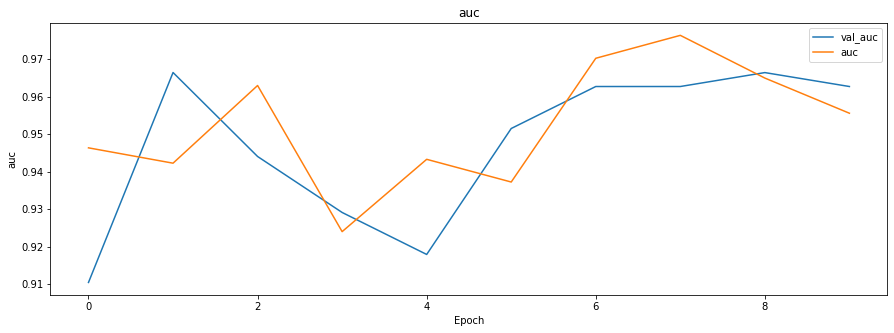

In [25]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_auc'],label='val_auc')
plt.plot(range(history.epoch[-1]+1),history.history['auc'],label='auc')
plt.title('auc'); plt.xlabel('Epoch'); plt.ylabel('auc');plt.legend(); 
plt.show()

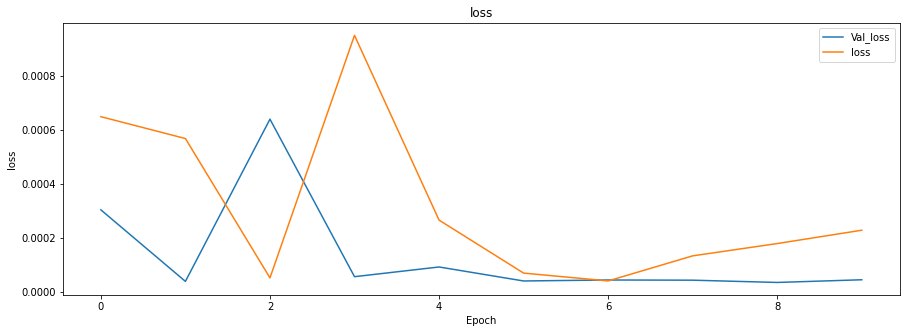

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

### ROC Curve

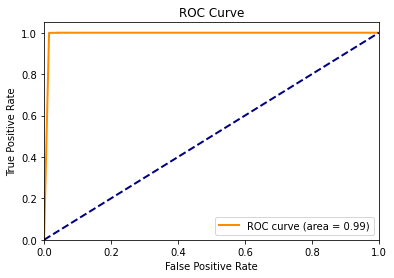

In [27]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
generate_results(y_test, y_pred)